In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from Bio import SeqIO
from nltk import bigrams
from nltk import trigrams


from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import dask.dataframe as dd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from itertools import cycle


In [3]:
import itertools
all_tri_grams = []
for p in itertools.product("ARNDCEQGHILKMFPSTWYV", repeat=3):
    tok = p[0] + p[1] + p[2]
    all_tri_grams.append(tok)
    
print len(all_tri_grams)

8000


In [4]:
"""
Writing a method to build tri-grams, as it is being frequently needed
input: fasta_file
output: a csv type file of tri-gram values
"""


"""
Writing a method to build tri-grams, as it is being frequently needed
input: fasta_file
output: a csv type file of tri-gram values
"""


def build_tri_grams(input_file, output_file):
    tri_dic = defaultdict(int)

    out_handle = open(output_file, "w")
    for rec in SeqIO.parse(input_file, "fasta"):
        tok = rec.description.split("|")[-1]
        #print tok
        #print tok[0], tok[-1]
        #if tok == 'toxin':
        tri_tokens = trigrams(rec.seq)

        # tri_tokens is a generator - you can only go through it once
        for item in ((tri_tokens)):
            if '-' in item:
                continue
            tri_str = item[0] + item[1] + item[2]
            #print bi_str
            tri_dic[tri_str] += 1

        for index, item in enumerate(sorted(all_tri_grams)):
            if index > 0:
                out_handle.write(',')
            out_handle.write("%s" % tri_dic[item])
        out_handle.write("\n")
        tri_dic.update({}.fromkeys(tri_dic, 0)) # setting all key values to be zero again


    out_handle.close()

In [155]:
# Getting curated context genes
# Loading the data into pandas dataframe
curated_context_data = pd.read_csv("all_curated_context_genes_trigrams", names=sorted(all_tri_grams))

# taking the values from panda into numpy array
cur_context_array = curated_context_data.values
print cur_context_array.shape
#print lacarray

cur_context_norm = normalize(cur_context_array.astype(float), norm = 'l1', axis = 1)
print np.sum(cur_context_norm, axis = 1)

(1240, 8000)
[ 1.  1.  1. ...,  1.  1.  1.]


In [156]:
# Getting the toxin genes from bagel
# Loading the data into pandas dataframe
import pandas as pd
class_1_data = pd.read_csv("class_1_tri_grams", names=sorted(all_tri_grams))
print class_1_data.shape
class_2_data = pd.read_csv("class_2_tri_grams", names=sorted(all_tri_grams))
print class_2_data.shape

array1 = class_1_data.values
#print array
array2 = class_2_data.values
total_array = np.vstack((array1, array2))
#print total_array

norm1 = normalize(total_array.astype(float), norm = 'l1', axis = 1)
#print np.sum(norm1, axis = 1)

(160, 8000)
(229, 8000)


In [157]:
# Getting experimentally verified context genes
seqs_for_testing_data = pd.read_csv("seqs_for_testing_without_toxins_tri_grams", names=sorted(all_tri_grams))

# taking the values from panda into numpy array
seqarray = seqs_for_testing_data.values
print seqarray.shape
#print seqarray

seqnewnorm = normalize(seqarray.astype(float), norm = 'l1', axis = 1)
print np.sum(seqnewnorm, axis = 1)

(54, 8000)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [158]:
# Not normalized
bagel_experi_context = np.vstack((total_array.astype(float), seqarray.astype(float), cur_context_array.astype(float)))

# Normalized
#bagel_experi_context = np.vstack((norm1.astype(float), seqnewnorm.astype(float), cur_context_norm.astype(float)))
print bagel_experi_context.shape
print bagel_experi_context[0, :]

(1683, 8000)
[ 0.  0.  0. ...,  0.  0.  0.]


In [159]:
# Splitting data into training and test set 
#np.random.shuffle(bagel_experi_context)

y = np.vstack((np.zeros((norm1.shape[0], 1)), np.ones((seqnewnorm.shape[0] + cur_context_norm.shape[0],1))))

# Shuffle in unision
bagel_experi_context, y = shuffle(bagel_experi_context, y, random_state = 0)

#x_train, x_test = bagel_experi_context[:1040,:], bagel_experi_context[1040:1680 ,:]
#StratifiedKFold(np.reshape(y_train, (1040, )), n_folds=10, shuffle=True, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(bagel_experi_context, y, test_size=0.3, random_state=42, 
                                                   stratify = y)
#y_train,  y_test = y[:1040, :], y[1040:1680 , :]
#y_train, y_val, y_test = y[:800, :], y[800:1040, ], y[1040:1680 , :]

# we are not using y_val for autoencoders - lets check if it improves accuracy
#x_train, x_val, x_test = bagel_experi_context[:800,:], bagel_experi_context[800:1040,:], bagel_experi_context[1040:1680 ,:]

# for the Vanilla classifier only
# X_main = bagel_experi_context[:1680, :]
# y_main = y[:1680, :]

print y_train.shape
print y_test.shape
#print y

(1178, 1)
(505, 1)


In [160]:
print x_train.shape
print x_test.shape
print y_train.shape
print y_test[y_test == 0].shape
print y_test[y_test == 1].shape
print y_test.shape
#print x_train[0, :][0:500]

(1178, 8000)
(505, 8000)
(1178, 1)
(117,)
(388,)
(505, 1)


In [161]:
from sklearn.utils.testing import (assert_array_almost_equal, assert_equal,
                                   assert_raises)

tsvd = TruncatedSVD(n_components = 256, random_state=0)
#tsvd_val = TruncatedSVD(n_components = 256, random_state=0)
x_train_reduced = tsvd.fit_transform(x_train)
#x_train_val_reduced = tsvd_val.fit_transform(x_train_val_a)
print x_train_reduced.shape
x_train_reduced_back = tsvd.inverse_transform(x_train_reduced)
#print x_train_reduced_back
print x_train_reduced_back.shape

#assert_array_almost_equal(x_train_a, x_train_reduced_back, decimal=3)

(1178, 256)
(1178, 8000)


In [6]:
build_tri_grams('less_than_30_pos_neg_bacteriocin.fa', 'less_than_30_pos_neg_bacteriocin_trigrams')

In [5]:
final_bac_data = pd.read_csv("less_than_30_pos_neg_bacteriocin_trigrams", names=sorted(all_tri_grams))

# taking the values from panda into numpy array
final_bac_array = final_bac_data.values
print final_bac_array.shape

(692, 8000)


In [6]:
y = np.vstack((np.ones((346, 1)), np.zeros((346,1))))

print final_bac_array.shape
print y.shape

(692, 8000)
(692, 1)


In [7]:
c, r = y.shape
y = y.reshape(c,)
print y.shape

(692,)


# TruncatedSVD

In [162]:
"""
Compressing the test data
"""
x_test_truncated_compressed = tsvd.transform(x_test)
print x_test_truncated_compressed.shape

(505, 256)


In [8]:
# display a 2D plot of the digit classes in the latent space
# plt.cm.get_cmap("brg", 3)
#import matplotlib
#x_test_encoded = encoder.predict(x_test)
#print x_test_encoded.shape
#colors = ['red','green','blue','purple']
X_reduced = TruncatedSVD(n_components=200, random_state=0).fit_transform(final_bac_array)
X_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X_reduced)
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 692 / 692
[t-SNE] Mean sigma: 1.470305
[t-SNE] Iteration 25: error = 1.2395595, gradient norm = 0.0154324
[t-SNE] Iteration 50: error = 1.2599550, gradient norm = 0.0138820
[t-SNE] Iteration 75: error = 1.0850648, gradient norm = 0.0143220
[t-SNE] Iteration 100: error = 1.1383300, gradient norm = 0.0137383
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.138330
[t-SNE] Iteration 125: error = 1.0328325, gradient norm = 0.0128541
[t-SNE] Iteration 150: error = 1.0861367, gradient norm = 0.0127409
[t-SNE] Iteration 175: error = 1.1027811, gradient norm = 0.0114554
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 1.138330


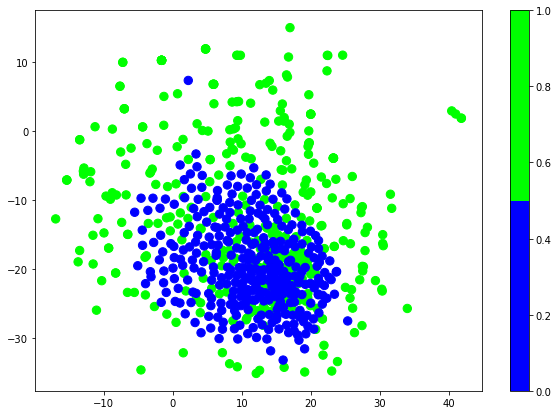

In [9]:
plt.scatter(vis_x, vis_y, c = y, cmap = plt.cm.get_cmap("brg", 2), s = 70)
#plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train_val_a, cmap = plt.cm.get_cmap("brg", 3), s = 70)
#plt.scatter(vis_x, vis_y, s = 70)
plt.colorbar()
plt.show()

In [165]:
print tsvd.explained_variance_ratio_.sum()

0.624855055807


In [10]:
print X_reduced.shape

(692, 200)


## SVM with input compressed - TruncatedSVD

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'clf__gamma': 0.0001, 'clf__C': 1000.0, 'clf__kernel': 'rbf'}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
{'clf__gamma': 0.001, 'clf__C': 100.0, 'clf__kernel': 'rbf'}
Precision 0.896551724138
Recall: 0.742857142857
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.85
Recall: 0.971428571429
F1: 0.906666666667
{'clf__C': 1.0, 'clf__kernel': 'linear'}
Precision 0.815789473684
Recall: 0.885714285714
F1: 0.849315068493
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Precision 0.931034482759
Recall: 0.771428571429
F1: 0.84375
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Precision 0.970588235294
Recall: 0.942857142857
F1: 0.95652173913
{'clf__gamma': 0.001, 'clf__C': 1000.0, 'clf__kernel': 'rbf'}
Precision 0.65625
Recall: 0.617647058824
F1: 0.636363636364
{'clf__gamma': 0.0001, 'clf__C': 1000.0, 'clf__kernel': 'rbf'}
Precision 0.90625
Recall: 0.852941176471
F1: 0.878787878788
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Precision 0.857142857143
Recall: 0.70588235

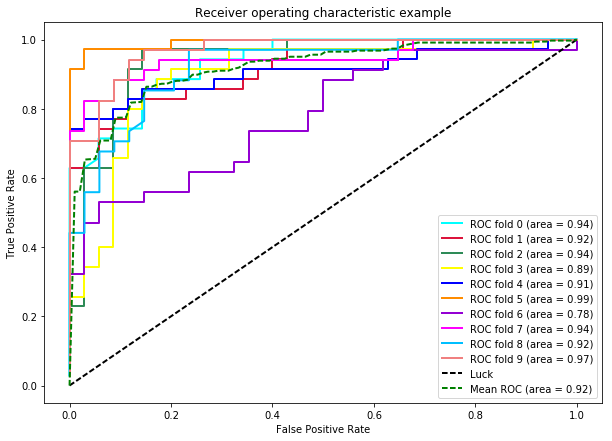

In [15]:
"""
Manual nested cross validation and ROC curve from that

10-fold-------------------------------------------


"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []


# Outer cv
for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
    pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(X_reduced[train], y[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(X_reduced[test])
    precision_s = precision_score(y[test], scores)
    recall_s = recall_score(y[test], scores)
    f1_s = f1_score(y[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(X_reduced[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print "Precision mean and std:", np.mean(precision_scores), np.std(precision_scores) 
print "Recall mean and std:", np.mean(recall_scores), np.std(recall_scores)
print "F1 meand and std:", np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(X_reduced, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
"""
10 fold Manual nested cross validation 50 times
"""
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
        pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(X_reduced[train], y[train])

        scores = gs.best_estimator_.predict(X_reduced[test])
        precision_s = precision_score(y[test], scores)
        recall_s = recall_score(y[test], scores)
        f1_s = f1_score(y[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
    precision_scores_std_list.append(np.std(precision_scores))
    recall_scores_std_list.append(np.std(recall_scores))
    f1_scores_std_list.append(np.std(f1_scores))
    
print 'Precision for 10 times:', np.mean(precision_scores_mean_list), np.std(precision_scores_std_list)
print 'Recall for 10 times:', np.mean(recall_scores_mean_list), np.std(recall_scores_std_list)
print 'F1 for 10 times:', np.mean(f1_scores_mean_list), np.std(f1_scores_std_list)

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Loop: 0
Precision: 0.863250357701 0.073897763811
Recall: 0.812016806723 0.0684490277643
F1: 0.834973693018 0.059418638524
Loop: 1
Precision: 0.874643389162 0.0471498459682
Recall: 0.82025210084 0.0581564212991
F1: 0.844522664059 0.034746856775
Loop: 2
Precision: 0.879110091758 0.0616120588179
Recall: 0.823697478992 0.0542310519078
F1: 0.848334961192 0.0388795582776
Loop: 3
Precision: 0.868021681774 0.0458344706758
Recall: 0.803697478992 0.0520142951566
F1: 0.833426779577 0.0386152482079
Loop: 4
Precision: 0.857318911301 0.0756605296052
Recall: 0.823193277311 0.0908995135257
F1: 0.83795122907 0.0725071424887
Loop: 5
Precision: 0.883513646639 0.0436232492622
Recall: 0.789159663866 0.0797916306939
F1: 0.829341350833 0.0303233221093
Loop: 6
Precision: 0.853976282432 0.0397788922904
Recall: 0.835462184874 0.0633223248776
F1: 0.843162717886 0.0403681163447
Loop: 7
Precision: 0.879670775952 0.0422222838485
Recall: 0.814705882353 0.113215609209
F1: 0.840134794251 0.0640048524641
Loop: 8
Precis

In [3]:
t = """Loop: 0
Precision: 0.863250357701 0.073897763811
Recall: 0.812016806723 0.0684490277643
F1: 0.834973693018 0.059418638524
Loop: 1
Precision: 0.874643389162 0.0471498459682
Recall: 0.82025210084 0.0581564212991
F1: 0.844522664059 0.034746856775
Loop: 2
Precision: 0.879110091758 0.0616120588179
Recall: 0.823697478992 0.0542310519078
F1: 0.848334961192 0.0388795582776
Loop: 3
Precision: 0.868021681774 0.0458344706758
Recall: 0.803697478992 0.0520142951566
F1: 0.833426779577 0.0386152482079
Loop: 4
Precision: 0.857318911301 0.0756605296052
Recall: 0.823193277311 0.0908995135257
F1: 0.83795122907 0.0725071424887
Loop: 5
Precision: 0.883513646639 0.0436232492622
Recall: 0.789159663866 0.0797916306939
F1: 0.829341350833 0.0303233221093
Loop: 6
Precision: 0.853976282432 0.0397788922904
Recall: 0.835462184874 0.0633223248776
F1: 0.843162717886 0.0403681163447
Loop: 7
Precision: 0.879670775952 0.0422222838485
Recall: 0.814705882353 0.113215609209
F1: 0.840134794251 0.0640048524641
Loop: 8
Precision: 0.887279536692 0.0543317218606
Recall: 0.794285714286 0.100318537933
F1: 0.835277211047 0.0721081020357
Loop: 9
Precision: 0.873884203259 0.0795559045316
Recall: 0.788907563025 0.075109128995
F1: 0.825856881121 0.0591431736775
Loop: 10
Precision: 0.870989599998 0.0245059601487
Recall: 0.81512605042 0.0745866371614
F1: 0.840162551438 0.0432610445454
Loop: 11
Precision: 0.884481299729 0.046650625885
Recall: 0.806722689076 0.0729254910913
F1: 0.841831826497 0.04853095393
Loop: 12
Precision: 0.899679571949 0.0500775645172
Recall: 0.823697478992 0.0418261219296
F1: 0.858559387495 0.0288571033416
Loop: 13
Precision: 0.886297309147 0.0547850410116
Recall: 0.803193277311 0.0437891733487
F1: 0.841242155832 0.0352473214929
Loop: 14
Precision: 0.855644955904 0.0771757053734
Recall: 0.806470588235 0.0735071274755
F1: 0.825230851177 0.0353810660082
Loop: 15
Precision: 0.865005373755 0.0650121008283
Recall: 0.815042016807 0.0553276315386
F1: 0.836984560764 0.043057161204
Loop: 16
Precision: 0.856322849008 0.0781862117619
Recall: 0.803193277311 0.0523790350014
F1: 0.826554839014 0.0477545435522
Loop: 17
Precision: 0.857827807194 0.043261113428
Recall: 0.79731092437 0.0885044314723
F1: 0.824017348405 0.0590904468948
Loop: 18
Precision: 0.869122423605 0.064378527583
Recall: 0.809579831933 0.0720410713856
F1: 0.835531285753 0.0520186268584
Loop: 19
Precision: 0.868890518084 0.0388861184529
Recall: 0.786386554622 0.0380845676274
F1: 0.824270694778 0.0199018855511
Loop: 20
Precision: 0.878219143036 0.0570351712534
Recall: 0.826890756303 0.0488509302766
F1: 0.850337777001 0.0383366511197
Loop: 21
Precision: 0.879927103331 0.0602666867678
Recall: 0.821008403361 0.0880887137814
F1: 0.84328659724 0.0378182989892
Loop: 22
Precision: 0.884277187313 0.0479122747901
Recall: 0.811176470588 0.0912057421162
F1: 0.842245442711 0.0525212523662
Loop: 23
Precision: 0.88982046187 0.0696486661215
Recall: 0.837731092437 0.0774281628421
F1: 0.858469351729 0.0426904374682
Loop: 24
Precision: 0.875240123501 0.0527463854622
Recall: 0.79756302521 0.0843594104618
F1: 0.830837597897 0.0456600527528
Loop: 25
Precision: 0.877272637716 0.0428036371359
Recall: 0.809327731092 0.0653092570835
F1: 0.839961563864 0.0417707721212
Loop: 26
Precision: 0.885029057234 0.0492855789935
Recall: 0.812100840336 0.0836665934712
F1: 0.844758464325 0.0570842515736
Loop: 27
Precision: 0.889986883713 0.063653170188
Recall: 0.774537815126 0.0527113190688
F1: 0.825727910599 0.034489438844
Loop: 28
Precision: 0.868709842286 0.0658229641919
Recall: 0.832521008403 0.0716753522413
F1: 0.846672179301 0.0438697013195
Loop: 29
Precision: 0.856139705882 0.0386012468505
Recall: 0.800840336134 0.0402274445984
F1: 0.826922335095 0.0321838380293
Loop: 30
Precision: 0.874755763226 0.0574151985132
Recall: 0.812016806723 0.0720899190569
F1: 0.839226706887 0.0422668837538
Loop: 31
Precision: 0.876419622736 0.0490783759881
Recall: 0.812268907563 0.0365294030656
F1: 0.841634271578 0.0239897010472
Loop: 32
Precision: 0.905324041545 0.0497029508927
Recall: 0.777478991597 0.0736901484429
F1: 0.834213445137 0.0469564556826
Loop: 33
Precision: 0.871773348614 0.0576729419778
Recall: 0.805882352941 0.0618089934401
F1: 0.83490671102 0.0361310274828
Loop: 34
Precision: 0.881923378346 0.053768301003
Recall: 0.826890756303 0.0740841022434
F1: 0.850336277999 0.0432749578571
Loop: 35
Precision: 0.904552177316 0.0769634451691
Recall: 0.788739495798 0.0658398937097
F1: 0.837189478915 0.0224883786784
Loop: 36
Precision: 0.856129771915 0.0617163580463
Recall: 0.802941176471 0.0546609427002
F1: 0.827057250861 0.043758604749
Loop: 37
Precision: 0.884418685475 0.0665610202406
Recall: 0.809579831933 0.0419683754488
F1: 0.842647426273 0.0241289459873
Loop: 38
Precision: 0.879370191044 0.0664080757987
Recall: 0.794369747899 0.0751751479818
F1: 0.832140411954 0.0544375124553
Loop: 39
Precision: 0.872289606785 0.0687904122628
Recall: 0.809075630252 0.0494840265067
F1: 0.836254764472 0.0290145653518
Loop: 40
Precision: 0.873462247201 0.056178778028
Recall: 0.829243697479 0.0340513492536
F1: 0.849451519547 0.0319389454789
Loop: 41
Precision: 0.850412909459 0.0504828203469
Recall: 0.814453781513 0.0856679723289
F1: 0.829720715602 0.0559261887659
Loop: 42
Precision: 0.870658968192 0.0292422705113
Recall: 0.832773109244 0.0635796342324
F1: 0.850180117085 0.0392819483963
Loop: 43
Precision: 0.872651163785 0.0536567766535
Recall: 0.818235294118 0.0649151369233
F1: 0.841815231469 0.0366488595105
Loop: 44
Precision: 0.867979773779 0.0713334217297
Recall: 0.801092436975 0.0623097202352
F1: 0.831176987367 0.0524816650464
Loop: 45
Precision: 0.889426162249 0.0557242666143
Recall: 0.797394957983 0.044165959941
F1: 0.838729842494 0.0259935001472
Loop: 46
Precision: 0.900592164407 0.0535443721291
Recall: 0.809495798319 0.0829059208358
F1: 0.848028512628 0.0441883859351
Loop: 47
Precision: 0.884313064577 0.0518814954588
Recall: 0.800588235294 0.0709335789951
F1: 0.838411616664 0.0473973667551
Loop: 48
Precision: 0.874310938679 0.0721951123602
Recall: 0.812100840336 0.0570292989294
F1: 0.839318071006 0.0435363721471
Loop: 49
Precision: 0.865445455231 0.0771590323428
Recall: 0.79756302521 0.0449032888068
F1: 0.827065319856 0.0338196494461"""
import numpy as np
from scipy import stats
precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []
with open('temp.txt', 'r') as in_handle:
    for line in in_handle:
        if line.split()[0] == 'Precision:':
            precision_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'Recall:':
            recall_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'F1:':
            f1_scores_mean_list.append(float(line.split()[1]))
            
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)
            


Precision mean for 50 times: 0.87551524331 Std. error: 0.00184467473379
Recall mean for 50 times: 0.808959663866 Std. error: 0.00202949034298
F1 mean for 50 times: 0.838121833636 Std. error: 0.00121989033008


In [56]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.972665850097
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}


In [57]:
from sklearn.model_selection import cross_val_score
clf = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf')
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
f1_scores = cross_val_score(clf, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(clf, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(clf, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.97506925  0.97765363  0.96901408  0.98333333  0.95821727]
Recall: [ 0.96703297  0.96685083  0.95027624  0.97790055  0.95027624]
Precision: [ 0.98324022  0.98870056  0.98850575  0.98882682  0.96629213]


In [58]:
#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn.svm import SVC
from sklearn import metrics

def create_model():
    # create your model using this function
    classifier = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf')
    return classifier 

models_svm_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_svm_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.90      0.95      0.92        55
        1.0       0.98      0.97      0.98       182

avg / total       0.96      0.96      0.96       237


Running Fold 2 / 5
(942,) (236,)
             precision    recall  f1-score   support

        0.0       0.90      0.96      0.93        55
        1.0       0.99      0.97      0.98       181

avg / total       0.97      0.97      0.97       236


Running Fold 3 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.85      0.96      0.90        54
        1.0       0.99      0.95      0.97       181

avg / total       0.96      0.95      0.95       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.95        54
        1.0       0.99      0.98      0.98       181

avg / total       0.97      0.97      0.97       235


Runn

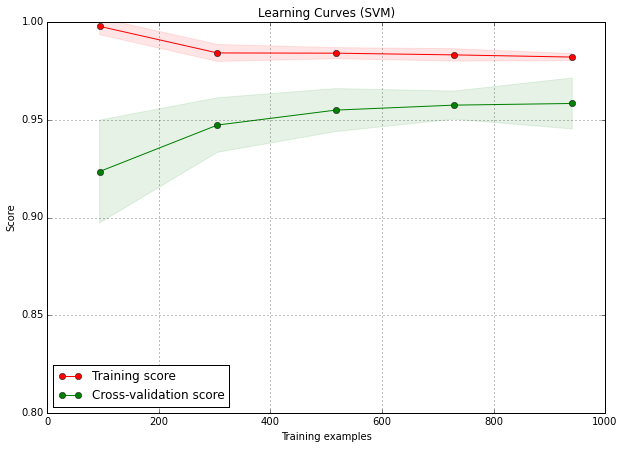

In [59]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim([0.8, 1.0])

    plt.legend(loc="best")
    return plt


title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf')
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [61]:
"""
Test set Evaluation
"""
classifier = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf')
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.90      0.97      0.94       117
        1.0       0.99      0.97      0.98       388

avg / total       0.97      0.97      0.97       505



## Logistic Regression Classifier - input compressed

{'logis__penalty': 'l2', 'logis__C': 0.001}
Precision 0.810810810811
Recall: 0.857142857143
F1: 0.833333333333
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.9
Recall: 0.771428571429
F1: 0.830769230769
{'logis__penalty': 'l2', 'logis__C': 0.001}
Precision 0.785714285714
Recall: 0.942857142857
F1: 0.857142857143
{'logis__penalty': 'l1', 'logis__C': 1.0}
Precision 0.857142857143
Recall: 0.857142857143
F1: 0.857142857143
{'logis__penalty': 'l2', 'logis__C': 0.001}
Precision 0.833333333333
Recall: 0.857142857143
F1: 0.845070422535
{'logis__penalty': 'l2', 'logis__C': 0.001}
Precision 0.813953488372
Recall: 1.0
F1: 0.897435897436
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.88
Recall: 0.647058823529
F1: 0.745762711864
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.933333333333
Recall: 0.823529411765
F1: 0.875
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.866666666667
Recall: 0.764705882353
F1: 0.8125
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.9642

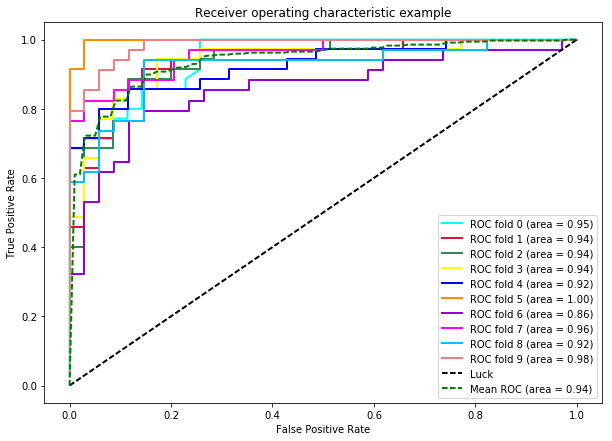

In [16]:
"""
Manual nested cross validation and ROC curve from that

10-fold-------------------------------------------


"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []


# Outer cv
for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
    pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(X_reduced[train], y[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(X_reduced[test])
    precision_s = precision_score(y[test], scores)
    recall_s = recall_score(y[test], scores)
    f1_s = f1_score(y[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(X_reduced[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print "Precision mean and std:", np.mean(precision_scores), np.std(precision_scores) 
print "Recall mean and std:", np.mean(recall_scores), np.std(recall_scores)
print "F1 mean and std:", np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(X_reduced, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
"""
10 fold Manual nested cross validation 50 times
"""
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
                 {'logis__C': param_range, 'logis__penalty': ['l2']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(X_reduced[train], y[train])

        scores = gs.best_estimator_.predict(X_reduced[test])
        precision_s = precision_score(y[test], scores)
        recall_s = recall_score(y[test], scores)
        f1_s = f1_score(y[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
    precision_scores_std_list.append(np.std(precision_scores))
    recall_scores_std_list.append(np.std(recall_scores))
    f1_scores_std_list.append(np.std(f1_scores))
    
print 'Precision for 10 times:', np.mean(precision_scores_mean_list), np.std(precision_scores_std_list)
print 'Recall for 10 times:', np.mean(recall_scores_mean_list), np.std(recall_scores_std_list)
print 'F1 for 10 times:', np.mean(f1_scores_mean_list), np.std(f1_scores_std_list)

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Loop: 0
Precision: 0.88496689757 0.0548317531131
Recall: 0.835630252101 0.0860006749595
F1: 0.856229277815 0.0513425886161
Loop: 1
Precision: 0.874164391323 0.0560657466912
Recall: 0.834705882353 0.0783327160627
F1: 0.852418694294 0.0593409258198
Loop: 2
Precision: 0.869871915299 0.0741835227313
Recall: 0.849579831933 0.0785289509049
F1: 0.854589593441 0.0405960353276
Loop: 3
Precision: 0.870032700275 0.0559338519501
Recall: 0.838571428571 0.0527506910581
F1: 0.852046435324 0.0343910629088
Loop: 4
Precision: 0.842259047259 0.0463500667436
Recall: 0.840672268908 0.108689089924
F1: 0.837762148439 0.0659068422082
Loop: 5
Precision: 0.851265429576 0.0623851652553
Recall: 0.829663865546 0.0608731166623
F1: 0.836763404066 0.0291751399136
Loop: 6
Precision: 0.868552908626 0.0740064946645
Recall: 0.855546218487 0.0639389781294
F1: 0.858564146621 0.0448670533433
Loop: 7
Precision: 0.88555634584 0.0466037928172
Recall: 0.840588235294 0.0699491376546
F1: 0.859861328289 0.0392882699941
Loop: 8
Pre

In [5]:
precision_scores_mean_list = [0.86773643527273292, 0.87253825063405155, 0.85983623651329177, 0.85579045180207414, 0.86452404896590951, 0.86996682755303445, 0.88730606055202821, 0.87425662974131568, 0.85787800237397016, 0.84561718966993971, 0.84924435034555668, 0.87031691974902292, 0.84515918269806944, 0.88228603777797332, 0.88498762698359479, 0.84695279845667026, 0.89360630826000842, 0.8810832791829496, 0.85621310878603618, 0.86779130475999544, 0.88767902971347967, 0.83866637893570195, 0.86778397022299458, 0.90411463032381612, 0.87971981313893077, 0.86321676326111807, 0.85421198687375155, 0.88802156250812436, 0.83971810130360058, 0.86679882962141031, 0.86480925707474943, 0.87621274873236121, 0.86198912809240069, 0.86803579868934444, 0.85367604402864961, 0.87575865226727301, 0.86842176901671009, 0.84446162418648196, 0.8333475295090963, 0.83943483142244746, 0.86798939631800209, 0.8615392040361215, 0.85043582291747322, 0.85935204435204438, 0.88725504628374652, 0.83464424054802255, 0.85044361448618599, 0.85429330614594523, 0.85453704032651401, 0.87790658942081268]
recall_scores_mean_list = [0.84134453781512608, 0.82084033613445373, 0.84689075630252086, 0.82126050420168073, 0.83151260504201685, 0.84411764705882353, 0.82991596638655474, 0.84630252100840342, 0.84705882352941175, 0.84168067226890764, 0.86100840336134454, 0.82966386554621852, 0.83243697478991607, 0.81999999999999995, 0.81798319327731106, 0.84689075630252098, 0.81756302521008395, 0.82890756302521018, 0.84621848739495797, 0.81554621848739506, 0.81504201680672261, 0.83218487394957974, 0.82294117647058818, 0.82386554621848751, 0.81252100840336128, 0.82084033613445373, 0.85596638655462187, 0.8322689075630253, 0.85521008403361343, 0.84705882352941164, 0.83210084033613452, 0.82974789915966396, 0.84647058823529409, 0.8373949579831933, 0.83243697478991607, 0.80605042016806716, 0.83815126050420174, 0.87025210084033622, 0.83453781512605052, 0.87831932773109234, 0.84647058823529409, 0.83420168067226896, 0.84689075630252098, 0.83285714285714296, 0.82672268907563018, 0.85823529411764699, 0.84378151260504208, 0.8360504201680673, 0.85798319327731087, 0.85848739495798321]
f1_scores_mean_list = [0.8495970029571065, 0.84299825565560926, 0.85091209408664648, 0.83469013704845363, 0.84251250521592769, 0.85365976152300116, 0.85392253109037775, 0.85350210500699342, 0.85041584981295648, 0.83863221819701561, 0.85327297708459471, 0.84634931848437545, 0.83378137472115754, 0.84558133623704923, 0.84598157228247128, 0.84453030790129091, 0.85254869828239388, 0.85114196201051961, 0.84633337755335525, 0.83908501571724481, 0.84883240618054534, 0.83241502016364122, 0.84103352406333765, 0.85768870512224082, 0.84183672759346673, 0.83549543991065889, 0.85142197826863908, 0.85592180205506074, 0.84305864321556379, 0.85548884336194675, 0.84593356465483982, 0.8480154431473389, 0.85049869307158799, 0.84759454286591596, 0.83941824420105315, 0.83807928126957987, 0.85087583453571458, 0.85383033574440059, 0.82891928856674046, 0.85489772504238337, 0.85250737443058466, 0.84430822102460323, 0.84354726132585367, 0.84298744873147824, 0.8512042200541885, 0.84357297646098428, 0.84337859040762608, 0.83788192082147861, 0.85230022251850457, 0.8647281372444573]

print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

Precision mean for 50 times: 0.864151316077 Std. error: 0.00230756783393
Recall mean for 50 times: 0.837043697479 Std. error: 0.00217484034403
F1 mean for 50 times: 0.846542416338 Std. error: 0.00102982463631


In [27]:
print precision_scores_mean_list
print recall_scores_mean_list
print f1_scores_mean_list

[0.86773643527273292, 0.87253825063405155, 0.85983623651329177, 0.85579045180207414, 0.86452404896590951, 0.86996682755303445, 0.88730606055202821, 0.87425662974131568, 0.85787800237397016, 0.84561718966993971, 0.84924435034555668, 0.87031691974902292, 0.84515918269806944, 0.88228603777797332, 0.88498762698359479, 0.84695279845667026, 0.89360630826000842, 0.8810832791829496, 0.85621310878603618, 0.86779130475999544, 0.88767902971347967, 0.83866637893570195, 0.86778397022299458, 0.90411463032381612, 0.87971981313893077, 0.86321676326111807, 0.85421198687375155, 0.88802156250812436, 0.83971810130360058, 0.86679882962141031, 0.86480925707474943, 0.87621274873236121, 0.86198912809240069, 0.86803579868934444, 0.85367604402864961, 0.87575865226727301, 0.86842176901671009, 0.84446162418648196, 0.8333475295090963, 0.83943483142244746, 0.86798939631800209, 0.8615392040361215, 0.85043582291747322, 0.85935204435204438, 0.88725504628374652, 0.83464424054802255, 0.85044361448618599, 0.8542933061459

In [62]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.974029636872
{'logis__penalty': 'l2', 'logis__C': 0.1}


In [63]:
from sklearn.model_selection import cross_val_score
logis = LogisticRegression(C = 0.1, penalty = 'l2')
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
f1_scores = cross_val_score(logis, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(logis, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(logis, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.97506925  0.98060942  0.96952909  0.98071625  0.96418733]
Recall: [ 0.96703297  0.97790055  0.96685083  0.98342541  0.96685083]
Precision: [ 0.98324022  0.98333333  0.97222222  0.97802198  0.96153846]


In [64]:
#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

def create_model():
    # create your model using this function
    classifier = LogisticRegression(C = 0.1, penalty = 'l2')
    return classifier 

models_logis_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.90      0.95      0.92        55
        1.0       0.98      0.97      0.98       182

avg / total       0.96      0.96      0.96       237


Running Fold 2 / 5
(942,) (236,)
             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94        55
        1.0       0.98      0.98      0.98       181

avg / total       0.97      0.97      0.97       236


Running Fold 3 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.89      0.91      0.90        54
        1.0       0.97      0.97      0.97       181

avg / total       0.95      0.95      0.95       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.94      0.93      0.93        54
        1.0       0.98      0.98      0.98       181

avg / total       0.97      0.97      0.97       235


Runn

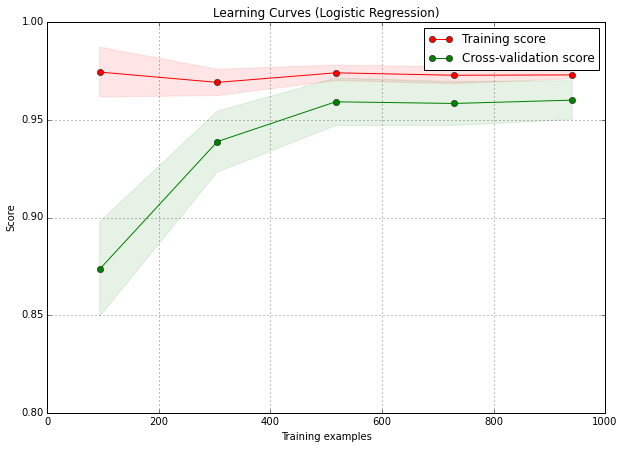

In [65]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim([0.0, 1.0])
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.ylim([0.8, 1.0])
    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = LogisticRegression(C = 0.1, penalty = 'l2')
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [66]:
"""
On Test Set
"""
from sklearn.metrics import roc_curve, auc

classifier = LogisticRegression(C = 0.1, penalty = 'l2')
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94       117
        1.0       0.98      0.98      0.98       388

avg / total       0.97      0.97      0.97       505



## K Nearest Neighbor Classifier - input compressed

In [67]:
"""
Grid Search for parameters
"""
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([('knn', KNeighborsClassifier())])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'knn__n_neighbors': [2,3,4,5,6,7,8,9,10], 'knn__weights': ['uniform', 'distance'], 
              'knn__leaf_size': [20, 25, 30, 35, 40, 45, 50]}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.821846081678
{'knn__leaf_size': 20, 'knn__weights': 'distance', 'knn__n_neighbors': 2}


In [86]:
print gs.best_score_

0.821846081678


In [87]:
"""
Doing cross validation and checking precision, recall, F1 score
"""
from sklearn.model_selection import cross_val_score

knn_cl = KNeighborsClassifier(weights = 'distance', n_neighbors = 2, leaf_size = 20)
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)

f1_scores = cross_val_score(knn_cl, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(knn_cl, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(knn_cl, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.80246914  0.81619938  0.82634731  0.86060606  0.80379747]
Recall: [ 0.71428571  0.72375691  0.76243094  0.78453039  0.70165746]
Precision: [ 0.91549296  0.93571429  0.90196078  0.95302013  0.94074074]


In [81]:
"""
This manual cross validation is done to check on performance for individual classes
(check for 0.0s in toxin prediction)
"""

#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

def create_model():
    # create your model using this function
    classifier = KNeighborsClassifier(weights = 'distance', n_neighbors = 2, leaf_size = 20)
    return classifier 

models_logis_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.45      0.78      0.57        55
        1.0       0.92      0.71      0.80       182

avg / total       0.81      0.73      0.75       237


Running Fold 2 / 5
(942,) (236,)
             precision    recall  f1-score   support

        0.0       0.48      0.84      0.61        55
        1.0       0.94      0.72      0.82       181

avg / total       0.83      0.75      0.77       236


Running Fold 3 / 5
(943,) (235,)


/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


             precision    recall  f1-score   support

        0.0       0.48      0.72      0.57        54
        1.0       0.90      0.76      0.83       181

avg / total       0.80      0.75      0.77       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.55      0.87      0.67        54
        1.0       0.95      0.78      0.86       181

avg / total       0.86      0.80      0.82       235


Running Fold 5 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.46      0.85      0.60        54
        1.0       0.94      0.70      0.80       181

avg / total       0.83      0.74      0.76       235




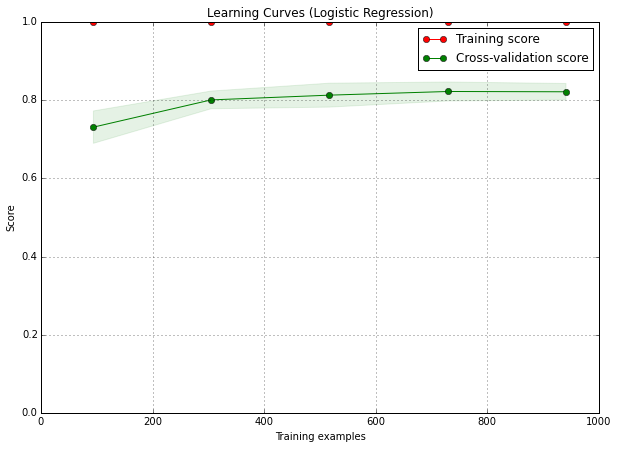

In [82]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.ylim([0.0, 1.0])
    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = KNeighborsClassifier(weights = 'distance', n_neighbors = 2, leaf_size = 20)
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [88]:
"""
Test set Evaluation
"""
classifier = KNeighborsClassifier(weights = 'distance', n_neighbors = 2, leaf_size = 20)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.44      0.85      0.58       117
        1.0       0.94      0.68      0.79       388

avg / total       0.82      0.72      0.74       505



/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## Decision Tree Classifier - input compressed

{'dect__criterion': 'gini', 'dect__max_depth': 10}
Precision 0.71875
Recall: 0.657142857143
F1: 0.686567164179
{'dect__criterion': 'entropy', 'dect__max_depth': 10}
Precision 0.657894736842
Recall: 0.714285714286
F1: 0.684931506849
{'dect__criterion': 'entropy', 'dect__max_depth': 9}
Precision 0.775
Recall: 0.885714285714
F1: 0.826666666667
{'dect__criterion': 'gini', 'dect__max_depth': 9}
Precision 0.777777777778
Recall: 0.8
F1: 0.788732394366
{'dect__criterion': 'gini', 'dect__max_depth': 8}
Precision 0.931034482759
Recall: 0.771428571429
F1: 0.84375
{'dect__criterion': 'entropy', 'dect__max_depth': 8}
Precision 0.857142857143
Recall: 0.857142857143
F1: 0.857142857143
{'dect__criterion': 'gini', 'dect__max_depth': 7}
Precision 0.677419354839
Recall: 0.617647058824
F1: 0.646153846154
{'dect__criterion': 'gini', 'dect__max_depth': 8}
Precision 0.806451612903
Recall: 0.735294117647
F1: 0.769230769231
{'dect__criterion': 'gini', 'dect__max_depth': 8}
Precision 0.694444444444
Recall: 0.73

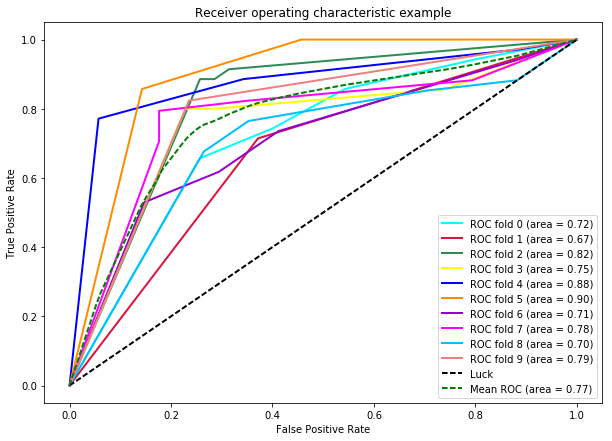

In [17]:
"""
Manual nested cross validation and ROC curve from that

10-fold-------------------------------------------


"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []


# Outer cv
for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
    pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
    #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(X_reduced[train], y[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(X_reduced[test])
    precision_s = precision_score(y[test], scores)
    recall_s = recall_score(y[test], scores)
    f1_s = f1_score(y[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(X_reduced[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print "Precision mean and std:", np.mean(precision_scores), np.std(precision_scores) 
print "Recall mean and std:", np.mean(recall_scores), np.std(recall_scores)
print "F1 mean and std:", np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(X_reduced, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [12]:
"""
10 fold Manual nested cross validation 50 times
"""
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
        pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
        #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(X_reduced[train], y[train])

        scores = gs.best_estimator_.predict(X_reduced[test])
        precision_s = precision_score(y[test], scores)
        recall_s = recall_score(y[test], scores)
        f1_s = f1_score(y[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
    precision_scores_std_list.append(np.std(precision_scores))
    recall_scores_std_list.append(np.std(recall_scores))
    f1_scores_std_list.append(np.std(f1_scores))
    
print 'Precision for 50 times:', np.mean(precision_scores_mean_list), np.std(precision_scores_std_list)
print 'Recall for 50 times:', np.mean(recall_scores_mean_list), np.std(recall_scores_std_list)
print 'F1 for 50 times:', np.mean(f1_scores_mean_list), np.std(f1_scores_std_list)

Loop: 0
Precision: 0.766771747157 0.0277003802558
Recall: 0.711176470588 0.0947704327674
F1: 0.734692586829 0.0522592383057
Loop: 1
Precision: 0.767020542941 0.0664507974449
Recall: 0.711008403361 0.0215114561143
F1: 0.736406888042 0.0326585379586
Loop: 2
Precision: 0.761859609437 0.0913458422626
Recall: 0.743109243697 0.0795288807813
F1: 0.750073037894 0.0738216815902
Loop: 3
Precision: 0.738784017207 0.0751122968908
Recall: 0.713697478992 0.0815957732172
F1: 0.722766121062 0.0613892397261
Loop: 4
Precision: 0.793360956966 0.09499181227
Recall: 0.70781512605 0.0966920203406
F1: 0.744374642276 0.0801845264485
Loop: 5
Precision: 0.787133857385 0.0553560633687
Recall: 0.716386554622 0.0898045724817
F1: 0.74565605517 0.0532803371019
Loop: 6
Precision: 0.761208436131 0.0418422998982
Recall: 0.754369747899 0.0607139804011
F1: 0.756850212958 0.0447752225028
Loop: 7
Precision: 0.765500620646 0.0494308381384
Recall: 0.725630252101 0.114550021853
F1: 0.741895112102 0.0800487614333
Loop: 8
Preci

In [6]:
precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []
with open('dec_tree_temp.txt', 'r') as in_handle:
    for line in in_handle:
        if line.split()[0] == 'Precision:':
            precision_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'Recall:':
            recall_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'F1:':
            f1_scores_mean_list.append(float(line.split()[1]))
            
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)
     

Precision mean for 50 times: 0.755204241674 Std. error: 0.00278740418579
Recall mean for 50 times: 0.719297478992 Std. error: 0.00259384047849
F1 mean for 50 times: 0.73354203282 Std. error: 0.00194939546205


In [89]:
"""
Grid Search for parameters
"""
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.952008114415
{'dect__criterion': 'entropy', 'dect__max_depth': 4}


In [93]:
"""
Doing cross validation and checking precision, recall, F1 score
"""
from sklearn.model_selection import cross_val_score
dect_cl = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
f1_scores = cross_val_score(dect_cl, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(dect_cl, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(dect_cl, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.95530726  0.94736842  0.94084507  0.97206704  0.94444444]
Recall: [ 0.93956044  0.94475138  0.92265193  0.96132597  0.93922652]
Precision: [ 0.97159091  0.95        0.95977011  0.98305085  0.94972067]


In [92]:
"""
This manual cross validation is done to check on performance for individual classes
(check for 0.0s in toxin prediction)
"""

#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

def create_model():
    # create your model using this function
    classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 1)
    return classifier 

models_logis_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.82      0.91      0.86        55
        1.0       0.97      0.94      0.96       182

avg / total       0.94      0.93      0.93       237


Running Fold 2 / 5
(942,) (236,)
             precision    recall  f1-score   support

        0.0       0.82      0.84      0.83        55
        1.0       0.95      0.94      0.95       181

avg / total       0.92      0.92      0.92       236


Running Fold 3 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82        54
        1.0       0.96      0.92      0.94       181

avg / total       0.92      0.91      0.91       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.88      0.94      0.91        54
        1.0       0.98      0.96      0.97       181

avg / total       0.96      0.96      0.96       235


Runn

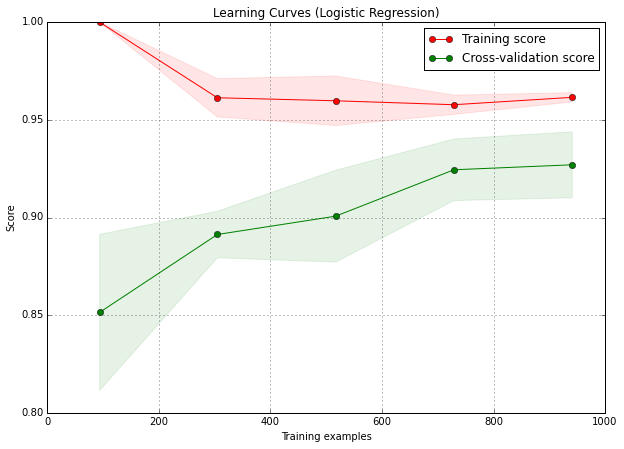

In [94]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.ylim([0.8, 1.0])
    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [95]:
"""
Test set Evaluation
"""
classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.87      0.90      0.88       117
        1.0       0.97      0.96      0.96       388

avg / total       0.95      0.94      0.94       505



## Random Forest Classifier - input compressed

{'randf__n_estimators': 17, 'randf__criterion': 'gini', 'randf__max_depth': None}
Precision 0.764705882353
Recall: 0.742857142857
F1: 0.753623188406
{'randf__n_estimators': 17, 'randf__criterion': 'gini', 'randf__max_depth': 10}
Precision 0.828571428571
Recall: 0.828571428571
F1: 0.828571428571
{'randf__n_estimators': 17, 'randf__criterion': 'entropy', 'randf__max_depth': 7}
Precision 0.815789473684
Recall: 0.885714285714
F1: 0.849315068493
{'randf__n_estimators': 20, 'randf__criterion': 'entropy', 'randf__max_depth': 8}
Precision 0.878787878788
Recall: 0.828571428571
F1: 0.852941176471
{'randf__n_estimators': 10, 'randf__criterion': 'entropy', 'randf__max_depth': 8}
Precision 0.852941176471
Recall: 0.828571428571
F1: 0.840579710145
{'randf__n_estimators': 17, 'randf__criterion': 'gini', 'randf__max_depth': 9}
Precision 0.909090909091
Recall: 0.857142857143
F1: 0.882352941176
{'randf__n_estimators': 15, 'randf__criterion': 'gini', 'randf__max_depth': 10}
Precision 0.741935483871
Recall

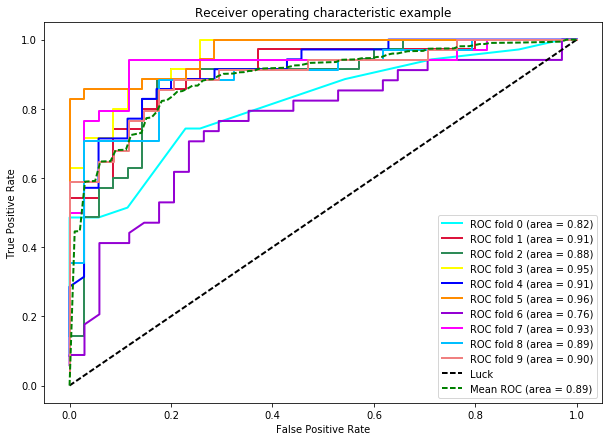

In [18]:
"""
Manual nested cross validation and ROC curve from that

10-fold-------------------------------------------


"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []


# Outer cv
for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
    pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
    #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
               'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
              'randf__max_depth': [3,4,5,6,7,8,9,10,None], 'randf__class_weight': ['balanced']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(X_reduced[train], y[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(X_reduced[test])
    precision_s = precision_score(y[test], scores)
    recall_s = recall_score(y[test], scores)
    f1_s = f1_score(y[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(X_reduced[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print "Precision mean and std:", np.mean(precision_scores), np.std(precision_scores) 
print "Recall mean and std:", np.mean(recall_scores), np.std(recall_scores)
print "F1 mean and std:", np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(X_reduced, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [13]:
"""
10 fold Manual nested cross validation 50 times
"""
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(X_reduced, y), colors):
        pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
        #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
               'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
              'randf__max_depth': [3,4,5,6,7,8,9,10,None], 'randf__class_weight': ['balanced']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(X_reduced[train], y[train])

        scores = gs.best_estimator_.predict(X_reduced[test])
        precision_s = precision_score(y[test], scores)
        recall_s = recall_score(y[test], scores)
        f1_s = f1_score(y[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
    precision_scores_std_list.append(np.std(precision_scores))
    recall_scores_std_list.append(np.std(recall_scores))
    f1_scores_std_list.append(np.std(f1_scores))
    
print 'Precision for 50 times:', np.mean(precision_scores_mean_list), np.std(precision_scores_std_list)
print 'Recall for 50 times:', np.mean(recall_scores_mean_list), np.std(recall_scores_std_list)
print 'F1 for 50 times:', np.mean(f1_scores_mean_list), np.std(f1_scores_std_list)

Loop: 0
Precision: 0.839677855746 0.0436346819938
Recall: 0.798319327731 0.0786718003573
F1: 0.81687185342 0.0527164324082
Loop: 1
Precision: 0.83351622299 0.0398542271739
Recall: 0.753781512605 0.0823049079608
F1: 0.788469439313 0.0476747388142
Loop: 2
Precision: 0.8436023245 0.0627257291699
Recall: 0.789243697479 0.096218891049
F1: 0.811828722327 0.0655599806736
Loop: 3
Precision: 0.827792815932 0.0450055696547
Recall: 0.752100840336 0.0895752596307
F1: 0.784623820994 0.0537700627461
Loop: 4
Precision: 0.844455489492 0.0518155163945
Recall: 0.785630252101 0.103573908641
F1: 0.81121067103 0.0707891302083
Loop: 5
Precision: 0.829163863789 0.0649850669866
Recall: 0.76025210084 0.0907866818125
F1: 0.789555286411 0.0610765787847
Loop: 6
Precision: 0.800069521085 0.0520614927581
Recall: 0.757226890756 0.0524715060832
F1: 0.776294012916 0.0373124557206
Loop: 7
Precision: 0.827942747486 0.0524245535162
Recall: 0.776890756303 0.0753798375349
F1: 0.79922798469 0.0528084995498
Loop: 8
Precision

In [4]:
precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []
with open('rand_forest_temp.txt', 'r') as in_handle:
    for line in in_handle:
        if line.split()[0] == 'Precision:':
            precision_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'Recall:':
            recall_scores_mean_list.append(float(line.split()[1]))
        if line.split()[0] == 'F1:':
            f1_scores_mean_list.append(float(line.split()[1]))
            
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)
     

Precision mean for 50 times: 0.833166142881 Std. error: 0.00205436655362
Recall mean for 50 times: 0.773401680672 Std. error: 0.00194454704956
F1 mean for 50 times: 0.799723045691 Std. error: 0.00153928406518


In [96]:
"""
Grid Search for parameters
"""
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 'randf__max_depth': [3,4,5,6,7,8,9,10,None],
             'randf__class_weight': ['balanced']}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.961399358582
{'randf__n_estimators': 20, 'randf__criterion': 'gini', 'randf__max_depth': 7, 'randf__class_weight': 'balanced'}


In [97]:
"""
Doing cross validation and checking precision, recall, F1 score
"""
from sklearn.model_selection import cross_val_score
randf_cl = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 7, class_weight = 'balanced',
                                 random_state = 1)
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)

f1_scores = cross_val_score(randf_cl, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(randf_cl, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(randf_cl, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


F1: [ 0.96089385  0.97206704  0.96089385  0.94972067  0.96338028]
Recall: [ 0.94505495  0.96132597  0.95027624  0.93922652  0.94475138]
Precision: [ 0.97727273  0.98305085  0.97175141  0.96045198  0.98275862]


In [98]:
"""
This manual cross validation is done to check on performance for individual classes
(check for 0.0s in toxin prediction)
"""

#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

def create_model():
    # create your model using this function
    classifier = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 7, class_weight = 'balanced',
                                 random_state = 1)
    return classifier 

models_logis_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.84      0.93      0.88        55
        1.0       0.98      0.95      0.96       182

avg / total       0.94      0.94      0.94       237


Running Fold 2 / 5
(942,) (236,)


/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91        55
        1.0       0.98      0.96      0.97       181

avg / total       0.96      0.96      0.96       236


Running Fold 3 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.84      0.91      0.88        54
        1.0       0.97      0.95      0.96       181

avg / total       0.94      0.94      0.94       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.81      0.87      0.84        54
        1.0       0.96      0.94      0.95       181

avg / total       0.93      0.92      0.92       235


Running Fold 5 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.84      0.94      0.89        54
        1.0       0.98      0.94      0.96       181

avg / total       0.95      0.94      0.95       235




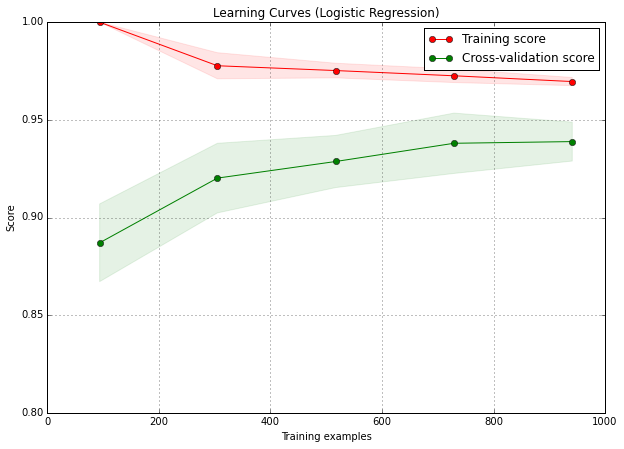

In [99]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.ylim([0.8, 1.0])
    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 7, class_weight = 'balanced',
                                 random_state = 1)
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [100]:
"""
Test set Evaluation
"""
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 7, class_weight = 'balanced',
                                 random_state = 1)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.84      0.96      0.89       117
        1.0       0.99      0.94      0.96       388

avg / total       0.95      0.95      0.95       505



/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [19]:
print 'hi'

hi


## Gradient Boosting Classifier - input compressed

In [103]:
"""
Grid Search for parameters
"""
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier

gamm = range(0,11)
max_dep = range(1, 8)
min_weight = range(1, 11)
pipe_xgb = Pipeline([('xgb', XGBClassifier())])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'xgb__gamma': gamm, 'xgb__min_child_weight': max_dep, 
               'xgb__max_depth': min_weight}]

cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_xgb, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_train_reduced, y_train)

print(gs.best_score_)
print(gs.best_params_)

/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nafizh/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.970660254438
{'xgb__gamma': 0, 'xgb__max_depth': 6, 'xgb__min_child_weight': 6}


In [104]:
"""
Doing cross validation and checking precision, recall, F1 score
"""
from sklearn.model_selection import cross_val_score
xgb_cl = XGBClassifier(gamma = 0, min_child_weight = 6, max_depth = 6)
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)

f1_scores = cross_val_score(xgb_cl, x_train_reduced, y_train, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(xgb_cl, x_train_reduced, y_train, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(xgb_cl, x_train_reduced, y_train, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.97237569  0.98071625  0.96666667  0.96969697  0.9637883 ]
Recall: [ 0.96703297  0.98342541  0.96132597  0.97237569  0.9558011 ]
Precision: [ 0.97777778  0.97802198  0.97206704  0.96703297  0.97191011]


In [105]:
"""
This manual cross validation is done to check on performance for individual classes
(check for 0.0s in toxin prediction)
"""

#results = cross_val_score(classifier_1, x_train, y_train, cv = kfold)
from sklearn import metrics

def create_model():
    # create your model using this function
    classifier = XGBClassifier(gamma = 0, min_child_weight = 6, max_depth = 6)
    return classifier 

models_logis_c = []
def train_and_evaluate_model(model, tr, tr_l, tr_te, tr_te_l):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(tr, tr_l)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(tr_te)
    print(metrics.classification_report(tr_te_l, scores))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print 
    models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, x_train_reduced[train], y_train[train], x_train_reduced[test], 
                             y_train[test])

Running Fold 1 / 5
(941,) (237,)
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91        55
        1.0       0.98      0.97      0.97       182

avg / total       0.96      0.96      0.96       237


Running Fold 2 / 5
(942,) (236,)
             precision    recall  f1-score   support

        0.0       0.94      0.93      0.94        55
        1.0       0.98      0.98      0.98       181

avg / total       0.97      0.97      0.97       236


Running Fold 3 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.88      0.91      0.89        54
        1.0       0.97      0.96      0.97       181

avg / total       0.95      0.95      0.95       235


Running Fold 4 / 5
(943,) (235,)
             precision    recall  f1-score   support

        0.0       0.91      0.89      0.90        54
        1.0       0.97      0.97      0.97       181

avg / total       0.95      0.95      0.95       235


Runn

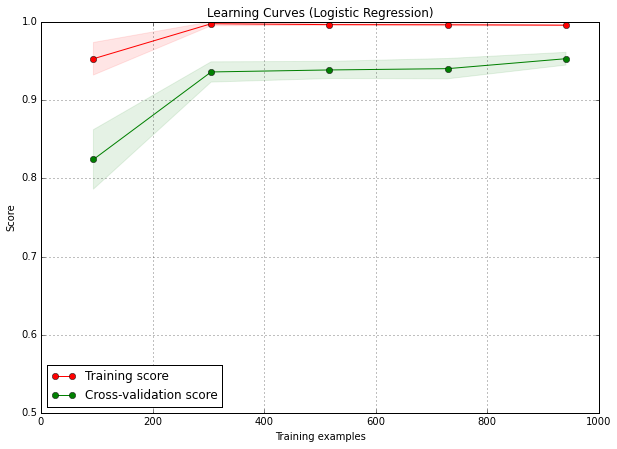

In [108]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.ylim([0.5, 1.0])
    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedKFold(np.reshape(y_train, (y_train.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
estimator = XGBClassifier(gamma = 0, min_child_weight = 6, max_depth = 6)
plot_learning_curve(estimator, title, x_train_reduced, y_train, cv=cv)

plt.show()

In [107]:
"""
Test set Evaluation
"""
classifier = XGBClassifier(gamma = 0, min_child_weight = 6, max_depth = 6)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict(x_test_truncated_compressed)
print(metrics.classification_report(y_test, scores))

             precision    recall  f1-score   support

        0.0       0.92      0.97      0.94       117
        1.0       0.99      0.97      0.98       388

avg / total       0.97      0.97      0.97       505



In [111]:
from sklearn.metrics import f1_score
y_true = [0, 1, 1, 0, 1, 0]
y_pred = [0, 1, 0, 0, 0, 1]

print f1_score(y_true, y_pred)

0.4


In [167]:
print len(y_test[y_test == 0])
print len(y_test[y_test == 1])

117
388


/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/nafizh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


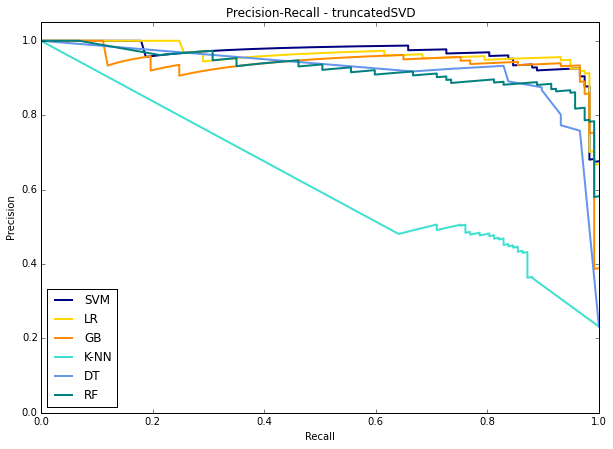

In [172]:
"""
Drawing a precision-recall curve for all the methods
"""

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

classifier = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf', probability = True)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
#print(metrics.classification_report(y_test, scores[]))
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
#average_precision = average_precision_score(y_test, svm_scores[:, 0])

plt.clf()
plt.plot(recall, precision, lw = 2, color='navy',
         label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall - truncatedSVD')

          
          
classifier = LogisticRegression(C = 0.1, penalty = 'l2')
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
plt.plot(recall, precision, lw = 2, color='gold',
         label='LR')


classifier = XGBClassifier(gamma = 0, min_child_weight = 6, max_depth = 6)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
plt.plot(recall, precision, lw = 2, color='darkorange',
         label='GB')


classifier = KNeighborsClassifier(weights = 'distance', n_neighbors = 2, leaf_size = 20)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
plt.plot(recall, precision, lw = 2, color='turquoise',
         label='K-NN')


classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
plt.plot(recall, precision, lw = 2, color='cornflowerblue',
         label='DT')

classifier = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 7, class_weight = 'balanced',
                                 random_state = 1)
classifier.fit(x_train_reduced, y_train)
scores = classifier.predict_proba(x_test_truncated_compressed)
precision, recall, thresholds = precision_recall_curve(y_test, scores[:, 0], pos_label = 0)
plt.plot(recall, precision, lw = 2, color='teal',
         label='RF')


plt.legend(loc="lower left")          
plt.show()

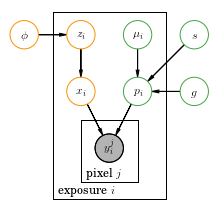

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)

from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

import daft

# Colors.
p_color = {"ec": "#46a546"}
s_color = {"ec": "#f89406"}

pgm = daft.PGM([3.6, 3.5], origin=[0.7, 0])

n = daft.Node("phi", r"$\phi$", 1, 3, plot_params=s_color)
n.va = "baseline"
pgm.add_node(n)
pgm.add_node(daft.Node("speckle_coeff", r"$z_i$", 2, 3, plot_params=s_color))
pgm.add_node(daft.Node("speckle_img", r"$x_i$", 2, 2, plot_params=s_color))

pgm.add_node(daft.Node("spec", r"$s$", 4, 3, plot_params=p_color))
pgm.add_node(daft.Node("shape", r"$g$", 4, 2, plot_params=p_color))
pgm.add_node(daft.Node("planet_pos", r"$\mu_i$", 3, 3, plot_params=p_color))
pgm.add_node(daft.Node("planet_img", r"$p_i$", 3, 2, plot_params=p_color))

pgm.add_node(daft.Node("pixels", r"$y_i ^j$", 2.5, 1, observed=True))

# Edges.
pgm.add_edge("phi", "speckle_coeff")
pgm.add_edge("speckle_coeff", "speckle_img")
pgm.add_edge("speckle_img", "pixels")

pgm.add_edge("spec", "planet_img")
pgm.add_edge("shape", "planet_img")
pgm.add_edge("planet_pos", "planet_img")
pgm.add_edge("planet_img", "pixels")

# And a plate.
pgm.add_plate(daft.Plate([1.5, 0.2, 2, 3.2], label=r"exposure $i$",
    shift=-0.1))
pgm.add_plate(daft.Plate([2, 0.5, 1, 1], label=r"pixel $j$",
    shift=-0.1))

# Render and save.
pgm.render()
pgm.figure.savefig("exoplanets.pdf")
pgm.figure.savefig("exoplanets.png", dpi=150)